# Check GPU Avalibility

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.8.2


'/device:GPU:0'

In [ ]:
!python --version

Python 3.7.13


# Import libraries

In [ ]:
# Libraries for do visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for do computational things
import numpy as np
import pandas as pd


import datetime
import os

# For evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# from tensorflow.keras.applications.mobilenetv2
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import MobileNetV2 ,Xception
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping

# Import Dataset

**Mount Google Drive to Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


**Extract Datset**

In [ ]:
from tqdm import tqdm
import zipfile

with zipfile.ZipFile('/content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip','r') as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, '/content/Dataset')
        except zipfile.error as e:
            pass

Extracting : 100%|██████████| 2025/2025 [00:03<00:00, 664.84it/s]


**Check inside Datast**

In [ ]:
DATASET_PATH = '/content/Dataset/Cats and Dogs Breed Clasification'

os.listdir(DATASET_PATH)

['test', 'train']

In [ ]:
class_names = sorted(os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/train'))
print(class_names)

['Abyssinian', 'Beagle', 'Bombay', 'British Shorthair', 'Chihuahua', 'Persian', 'Pomeranian', 'Pug', 'Shiba Inu', 'Siamese']


In [ ]:
def list_dir(class_names, slice='train'):
  return os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/{}/{}'.format(slice, class_names))

for i in class_names:
  print(i)
  print(len(list_dir(i, 'train')))
  print(len(list_dir(i, 'test')))

Abyssinian
153
50
Beagle
150
50
Bombay
150
50
British Shorthair
150
50
Chihuahua
150
50
Persian
150
50
Pomeranian
150
50
Pug
150
50
Shiba Inu
150
50
Siamese
150
50


# Image Preprocessing

In [ ]:
train_path = '/content/Dataset/Cats and Dogs Breed Clasification/train'
test_path = '/content/Dataset/Cats and Dogs Breed Clasification/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(299,299),
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb'
)

val_set = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(299,299),
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb'
)

breed_dict = train_set.class_indices
print(breed_dict)

Found 1500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
{'Abyssinian': 0, 'Beagle': 1, 'Bombay': 2, 'British Shorthair': 3, 'Chihuahua': 4, 'Persian': 5, 'Pomeranian': 6, 'Pug': 7, 'Shiba Inu': 8, 'Siamese': 9}


In [ ]:
# Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_val and y_val
X_val, y_val = val_set.next()

In [ ]:
X_train.shape # check shape

(32, 299, 299, 3)

**Plot Some Images in Dataset**

In [ ]:
class_dict = {v : k for k, v in train_set.class_indices.items()}

def plotimgs(X, y):
  labels=[]
  y_label = np.argmax(y, axis=1)
  
  for label in y_label:
    labels.append(class_dict[label])

  for idx in range(0,10):
      plt.figure(figsize=(5, 5))
      plt.imshow(X[idx])
      plt.title(labels[idx])

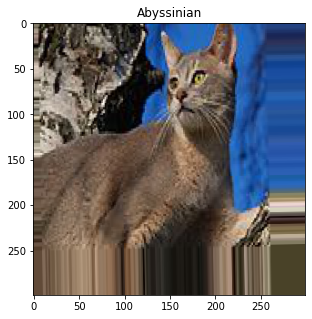

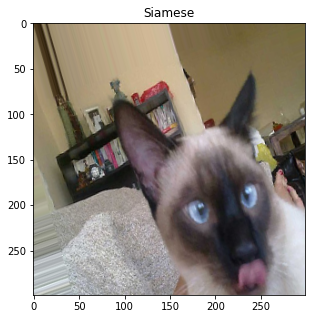

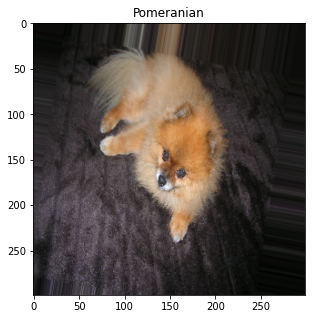

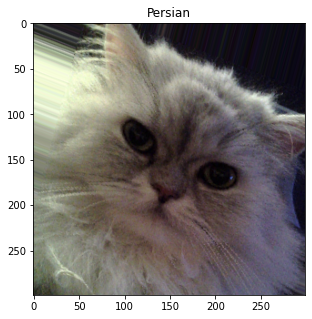

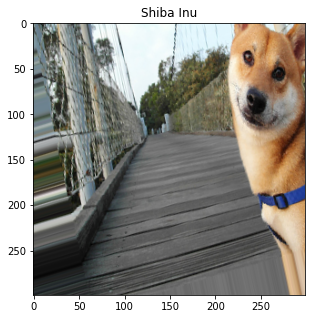

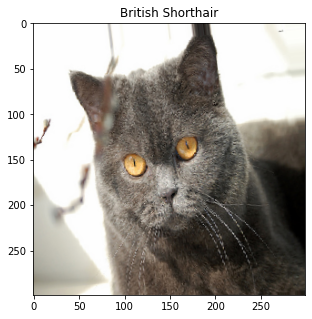

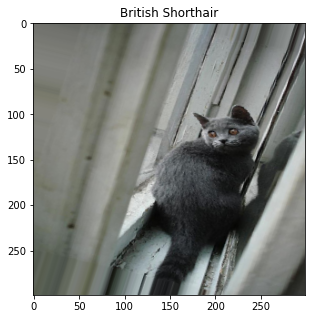

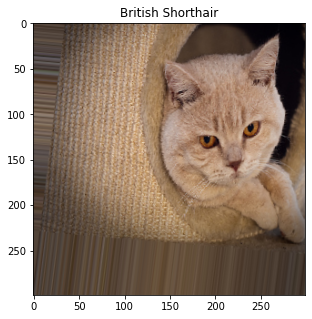

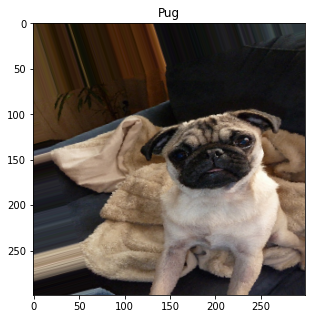

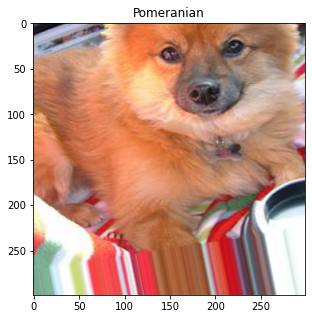

In [ ]:
plotimgs(X_train, y_train) # plot images in train set

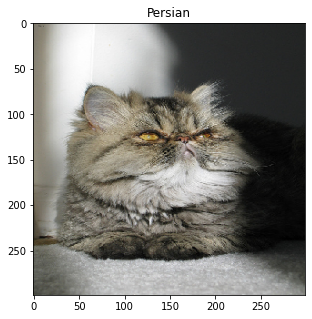

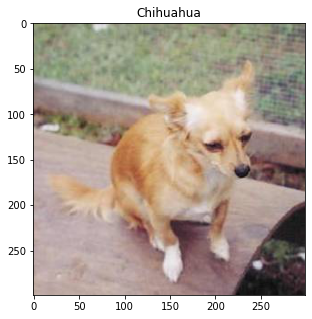

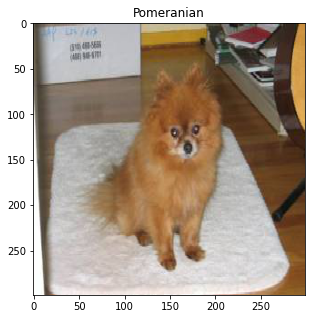

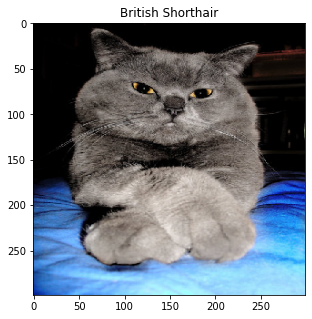

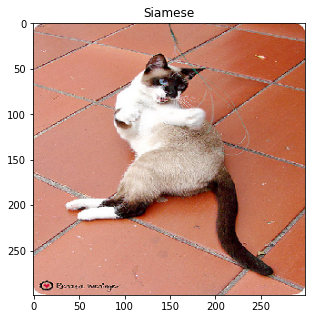

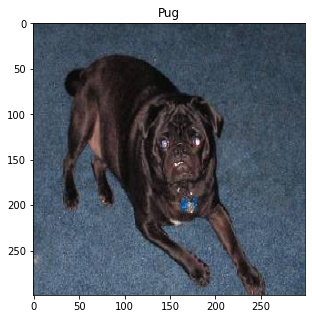

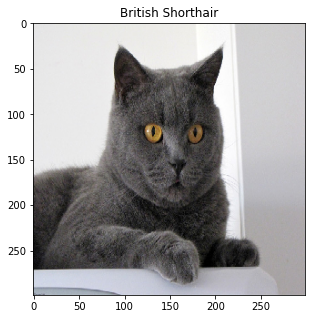

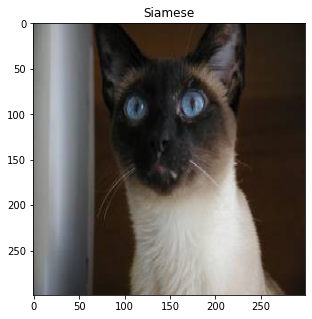

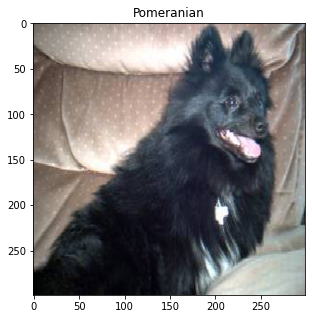

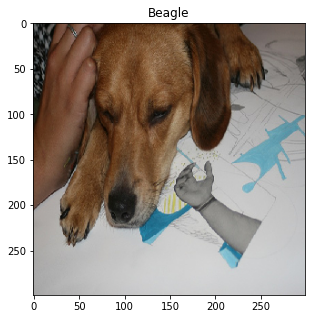

In [ ]:
plotimgs(X_val, y_val) #plot image in validation set

# Make function to evaluate models

In [ ]:
val_set.class_indices

{'Abyssinian': 0,
 'Beagle': 1,
 'Bombay': 2,
 'British Shorthair': 3,
 'Chihuahua': 4,
 'Persian': 5,
 'Pomeranian': 6,
 'Pug': 7,
 'Shiba Inu': 8,
 'Siamese': 9}

**Func evaluate model**

In [ ]:
def evaluate_model(model, X, y):
  print('Loss of the model is - ', model.evaluate(X, y)[0])
  print('Accuracy of the model is - ', model.evaluate(X, y)[1]*100, '%')
  predict = model.predict(X)
  # print(predict)
  predict = np.argmax(predict, axis=1)
  predict = predict.reshape(1, -1)[0]
  y_label = np.argmax(y, axis=1)
  print(classification_report(y_label, predict, target_names =['Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese']))

  conf_matrix = confusion_matrix(y_label, predict)
  # print(conf_matrix)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in ('Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese')],
                  columns = [i for i in ('Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese')])
  plt.figure(figsize = (3, 3))
  sns.heatmap(df_cm, annot=True)

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'green')
  val_acc_plot, = plt.plot(epochs, val_acc, 'blue')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'green')
  val_loss_plot, = plt.plot(epochs, val_loss, 'blue')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_hist(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

# **Model Building**

**Using Transfer Learning Xception as feature extractor to reduce training time, and improve accuracy**

In [ ]:
base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3),
    pooling='avg'
)

base_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


**Build Model**

In [ ]:
LEARNING_RATE = 0.001
clear_session()

model = Sequential([
    base_model,
    #GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                        

**show architecture model**

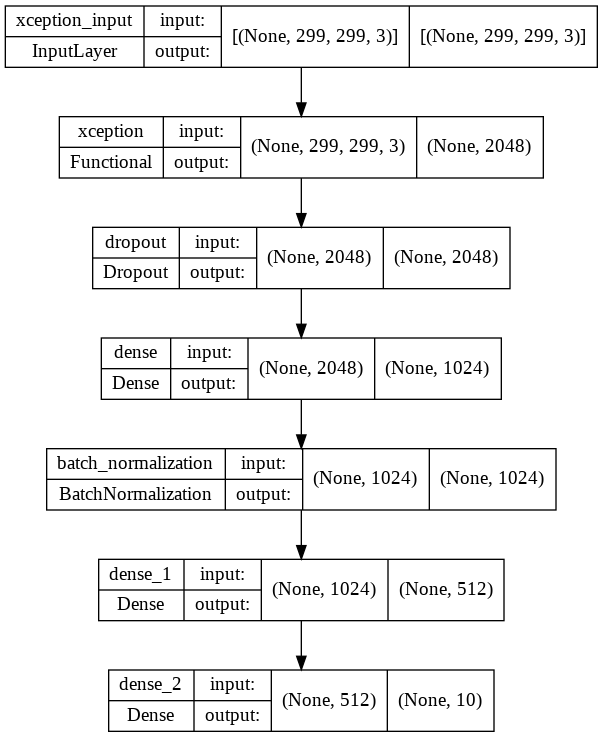

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Make Learning Rate Scheduler to reduce overfitting**

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 18:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks =[lr_cb]

**Train Model**

In [ ]:
# Trains for 25 epochs
history = model.fit(train_set,
                    epochs=20,
                    validation_data = val_set,
                    verbose = 1,
                    shuffle=True,
                    callbacks=callbacks
)

Epoch 1/20
47/47 [==============================] - 58s 912ms/step - loss: 0.4965 - accuracy: 0.9147 - val_loss: 0.3788 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 40s 853ms/step - loss: 0.3709 - accuracy: 0.9587 - val_loss: 0.6237 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 41s 864ms/step - loss: 0.3789 - accuracy: 0.9613 - val_loss: 0.3861 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 40s 857ms/step - loss: 0.3715 - accuracy: 0.9613 - val_loss: 0.5106 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 40s 858ms/step - loss: 0.3204 - accuracy: 0.9700 - val_loss: 0.4116 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 40s 854ms/step - loss: 0.3169 - accuracy: 0.9727 - val_loss: 0.3989 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 40s 849ms/st

**Plot model accuracy**

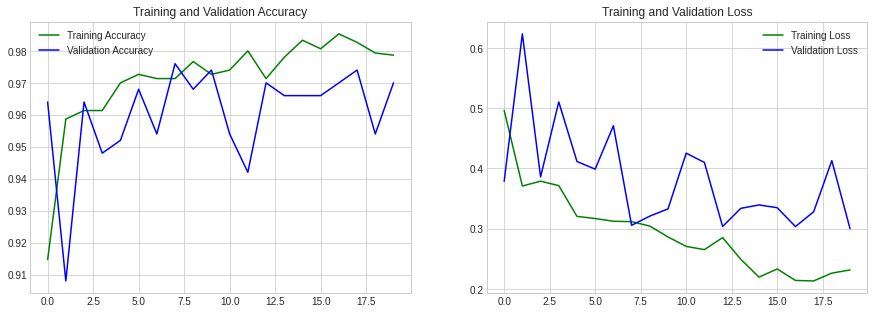

In [ ]:
plot_hist(history)

**Plot confussion matrix of model**

1/1 [==============================] - 1s 1s/step - loss: 0.2259 - accuracy: 0.9688
Loss of the model is -  0.22586776316165924
1/1 [==============================] - 0s 289ms/step - loss: 0.2259 - accuracy: 0.9688
Accuracy of the model is -  96.875 %
                   precision    recall  f1-score   support

       Abyssinian       1.00      1.00      1.00         2
           Beagle       1.00      1.00      1.00         4
           Bombay       1.00      0.67      0.80         3
British Shorthair       0.80      1.00      0.89         4
        Chihuahua       1.00      1.00      1.00         2
          Persian       1.00      1.00      1.00         4
       Pomeranian       1.00      1.00      1.00         5
              Pug       1.00      1.00      1.00         5
        Shiba Inu       1.00      1.00      1.00         1
          Siamese       1.00      1.00      1.00         2

         accuracy                           0.97        32
        macro avg       0.98      0.97

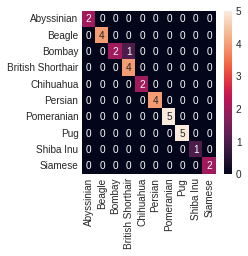

In [ ]:
evaluate_model(model, X_val, y_val)

**Freeze some layer to reduce loss**

In [ ]:
optimizer=Adam(0.0001)

# unfreeze last 10 layers and include them in training process
for layer in base_model.layers[-15:]:
  layer.trainable=True
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                        

**Train model with freeze some layers**

In [ ]:
# Trains for 25 epochs
history = model.fit(train_set,
                    epochs=10,
                    validation_data = val_set,
                    verbose = 1,
                    shuffle=True,
                    #callbacks=callbacks
)

Epoch 1/10
47/47 [==============================] - 44s 868ms/step - loss: 0.2200 - accuracy: 0.9787 - val_loss: 0.2635 - val_accuracy: 0.9680
Epoch 2/10
47/47 [==============================] - 40s 853ms/step - loss: 0.2171 - accuracy: 0.9773 - val_loss: 0.2602 - val_accuracy: 0.9680
Epoch 3/10
47/47 [==============================] - 42s 883ms/step - loss: 0.2136 - accuracy: 0.9747 - val_loss: 0.2562 - val_accuracy: 0.9700
Epoch 4/10
47/47 [==============================] - 40s 850ms/step - loss: 0.2058 - accuracy: 0.9767 - val_loss: 0.2605 - val_accuracy: 0.9720
Epoch 5/10
47/47 [==============================] - 40s 854ms/step - loss: 0.1947 - accuracy: 0.9780 - val_loss: 0.2501 - val_accuracy: 0.9740
Epoch 6/10
47/47 [==============================] - 40s 853ms/step - loss: 0.1872 - accuracy: 0.9800 - val_loss: 0.2421 - val_accuracy: 0.9740
Epoch 7/10
47/47 [==============================] - 40s 854ms/step - loss: 0.1825 - accuracy: 0.9787 - val_loss: 0.2530 - val_accuracy: 0.9680

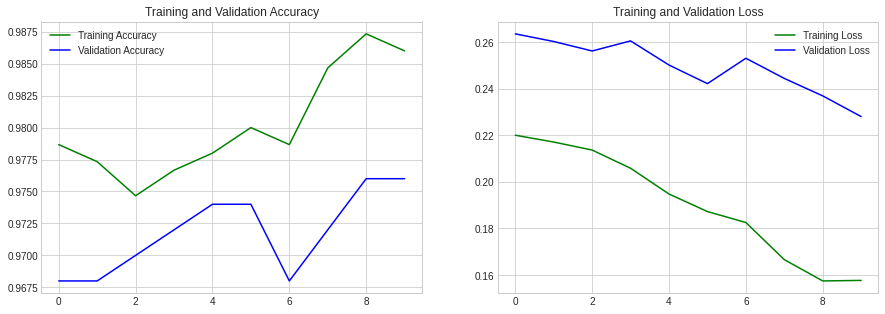

In [ ]:
plot_hist(history)

1/1 [==============================] - 1s 985ms/step - loss: 0.1209 - accuracy: 1.0000
Loss of the model is -  0.12087913602590561
1/1 [==============================] - 0s 288ms/step - loss: 0.1209 - accuracy: 1.0000
Accuracy of the model is -  100.0 %
                   precision    recall  f1-score   support

       Abyssinian       1.00      1.00      1.00         2
           Beagle       1.00      1.00      1.00         4
           Bombay       1.00      1.00      1.00         3
British Shorthair       1.00      1.00      1.00         4
        Chihuahua       1.00      1.00      1.00         2
          Persian       1.00      1.00      1.00         4
       Pomeranian       1.00      1.00      1.00         5
              Pug       1.00      1.00      1.00         5
        Shiba Inu       1.00      1.00      1.00         1
          Siamese       1.00      1.00      1.00         2

         accuracy                           1.00        32
        macro avg       1.00      1.

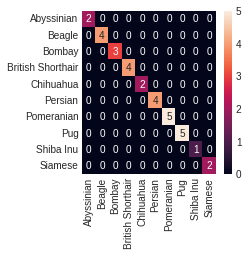

In [ ]:
evaluate_model(model, X_val, y_val)

Our model still overfitting because lack of data to train in our model

# Testing Model

**We test our model in val set directories each class consist 50 images**

In [ ]:
test_dir = '/content/Dataset/Cats and Dogs Breed Clasification/test'

for breed in breed_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, breed))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/Dataset/Cats and Dogs Breed Clasification/test/{breed}/{image}'
        img = load_img(img_path, target_size=(299, 299))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        breed_list = list(breed_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_breed = breed_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_breed == breed:
            correct_count += 1
    
    print(f'{breed} Predictions --> {correct_count}/50 correct')


Abyssinian Predictions --> 48/50 correct
Beagle Predictions --> 48/50 correct
Bombay Predictions --> 49/50 correct
British Shorthair Predictions --> 48/50 correct
Chihuahua Predictions --> 49/50 correct
Persian Predictions --> 49/50 correct
Pomeranian Predictions --> 49/50 correct
Pug Predictions --> 50/50 correct
Shiba Inu Predictions --> 48/50 correct
Siamese Predictions --> 50/50 correct


**We also test our model using image from internet**

we download images in internet and upload to gdrive after that make func to test model

In [ ]:
from keras.preprocessing import image
print(sorted(class_names))

testing = [
         '/content/gdrive/MyDrive/Dataset/Abyssinian.jpg',
         '/content/gdrive/MyDrive/Dataset/Beagle.jpg',
         '/content/gdrive/MyDrive/Dataset/British Shorthair.jpg',
         '/content/gdrive/MyDrive/Dataset/Chihuahua.jpg',
         '/content/gdrive/MyDrive/Dataset/Persian.jpg',
         '/content/gdrive/MyDrive/Dataset/Pomeranian.jpg',
         '/content/gdrive/MyDrive/Dataset/Pug.jpg',
         '/content/gdrive/MyDrive/Dataset/Shiba Inu.jpg',
         '/content/gdrive/MyDrive/Dataset/Siamese.jpg',
         '/content/gdrive/MyDrive/Dataset/bombay.jpg',
         ]

predict_result = []
percent = []

for fn in testing:
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(299,299), interpolation="nearest")
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  images = np.vstack([x])
  classes = model.predict(images)
  print(fn)
  predict_result.append(np.argmax(classes))
  percent.append(max(classes[0]))

['Abyssinian', 'Beagle', 'Bombay', 'British Shorthair', 'Chihuahua', 'Persian', 'Pomeranian', 'Pug', 'Shiba Inu', 'Siamese']
/content/gdrive/MyDrive/Dataset/Abyssinian.jpg
/content/gdrive/MyDrive/Dataset/Beagle.jpg
/content/gdrive/MyDrive/Dataset/British Shorthair.jpg
/content/gdrive/MyDrive/Dataset/Chihuahua.jpg
/content/gdrive/MyDrive/Dataset/Persian.jpg
/content/gdrive/MyDrive/Dataset/Pomeranian.jpg
/content/gdrive/MyDrive/Dataset/Pug.jpg
/content/gdrive/MyDrive/Dataset/Shiba Inu.jpg
/content/gdrive/MyDrive/Dataset/Siamese.jpg
/content/gdrive/MyDrive/Dataset/bombay.jpg


**Plot result**

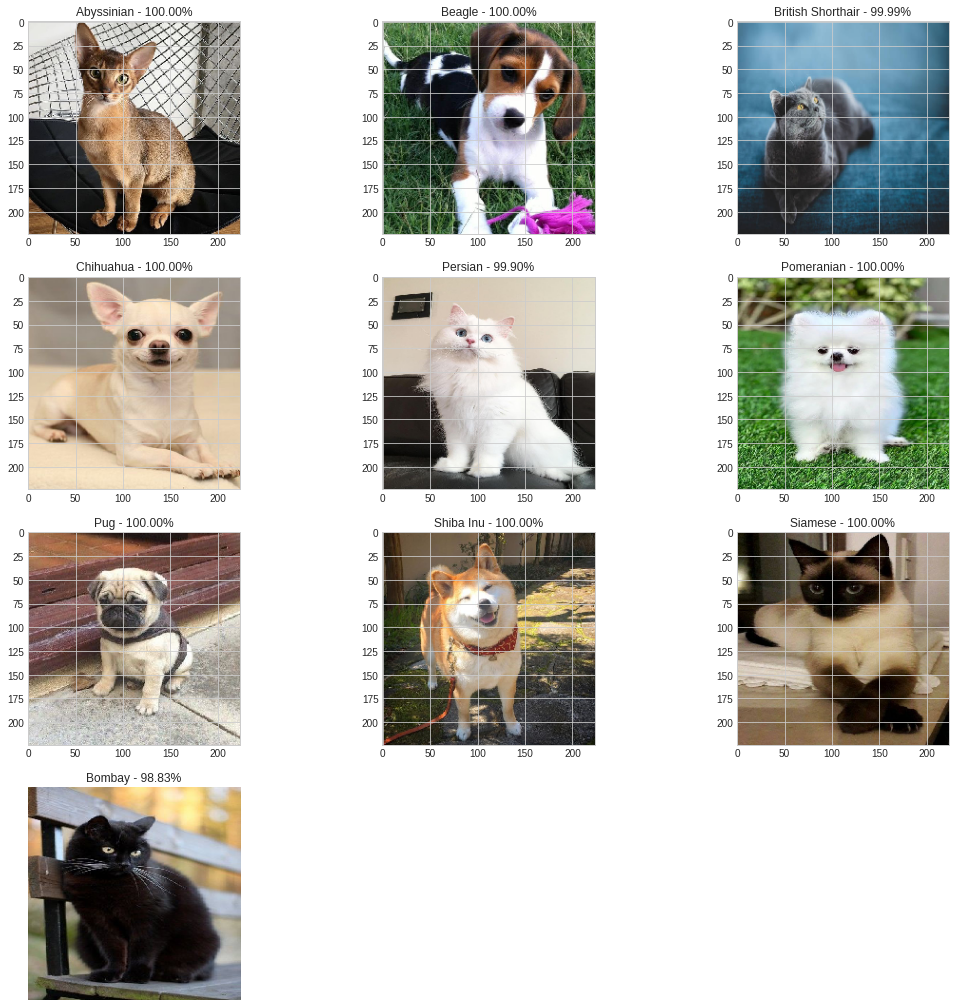

In [ ]:
plt.figure(figsize=(18, 18))

num_index = 0
for images in testing:
  plt.subplot((len(testing)/3)+1, 3, num_index+1)
  plt.imshow(image.load_img(images, color_mode="rgb", target_size=(224,224), interpolation="nearest"))
  plt.title("{} - {:0.2f}%".format(class_names[predict_result[num_index]], percent[num_index]*100))
  num_index += 1
plt.axis('off')
plt.show()

# Saving Model

**Save model to format Savedmodels and tflite we also create labels**

In [ ]:
from google.colab import files
def save_model_func(model_var, model_name):
  os.chdir('/content')
  try:
    os.mkdir('modelml')
  except:
    pass
  model_var.save('modelml/{}'.format(model_name))

  converter = tf.lite.TFLiteConverter.from_saved_model('modelml/{}'.format(model_name))

  lab_datagen = ImageDataGenerator(
    rescale=1./255
  )

  lab_flow = lab_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(299,299),
    shuffle=True,
    class_mode='categorical',
  )

  def representative_data_gen():
    for _ in range(300):
      img_with_label = lab_flow.next() # it returns (image and label) tuple
      yield [np.array(img_with_label[0], dtype=np.float32, ndmin=2)] # return image
    
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  tflite_model = converter.convert()

  with open('{}.tflite'.format(model_name), 'wb') as f:
    f.write(tflite_model)

  files.download('{}.tflite'.format(model_name))

  with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

  files.download('labels.txt')
  return tflite_model

In [ ]:
lite_model = save_model_func(model, 'catdogsclasifierXception')

INFO:tensorflow:Assets written to: modelml/catdogsclasifierXception/assets


INFO:tensorflow:Assets written to: modelml/catdogsclasifierXception/assets


Found 500 images belonging to 10 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save model in keras format as model.h5**

In [ ]:
model.save('/content/modelml/catsdogsclasifierXception.h5')

**Zip our saving model to easier download**

In [ ]:
!zip -r /content/catsdogsclasifiervXception.zip /content/modelml/catdogsclasifierXception

updating: content/modelml/catdogsclasifierXception/ (stored 0%)
updating: content/modelml/catdogsclasifierXception/variables/ (stored 0%)
updating: content/modelml/catdogsclasifierXception/variables/variables.data-00000-of-00001 (deflated 9%)
updating: content/modelml/catdogsclasifierXception/variables/variables.index (deflated 76%)
updating: content/modelml/catdogsclasifierXception/saved_model.pb (deflated 91%)
updating: content/modelml/catdogsclasifierXception/assets/ (stored 0%)
updating: content/modelml/catdogsclasifierXception/keras_metadata.pb (deflated 96%)


**Testing Model with tflite model format use google colab**

load model

In [ ]:
model = tf.keras.models.load_model('/content/modelml/catdogsclasifierXception')
lite_model = tf.lite.Interpreter(model_path='/content/catdogsclasifierXception.tflite')

In [ ]:
# interpreter = tf.lite.Interpreter(model_content=lite_model)
interpreter = lite_model

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = []

lab_datagen = ImageDataGenerator(
   rescale=1./255
)

lab_flow = lab_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(299,299),
    shuffle=True,
    class_mode='categorical',
)
test_labels, test_imgs = [], []
for _ in range(10):
  image_file = list(lab_flow.next())
  test_imgs.append(image_file[0])
  print(image_file[1])
  test_labels.append(np.argmax(image_file[1]))

  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details['quantization']
    image_file[0] = image_file[0] / input_scale + input_zero_point
  
  image_file[0] = image_file[0].astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], image_file[0])
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])[0]
  predictions.append(output)

Found 500 images belonging to 10 classes.
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


Plot image,predictions, and label

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
        
    plt.xlabel("{} {:0.2f}% ({})".format(class_names[predicted_label],
                                         np.max(predictions_array)*100,
                                         class_names[true_label]))

<class 'numpy.int64'> <class 'numpy.int64'>


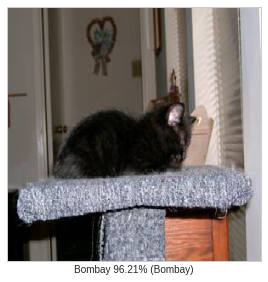

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()